# BIOMEDIN 260/RAD260: Problem Set 3 - Mammogram Project

## Spring 2019

## Name 1:
SUMI SINGH

## Name 2:

KAVITA KULKARNI

## Introduction

Breast cancer has the highest incidence and second highest mortality rate for women in the US.

Your task is to utilize machine learning to study mammograms in any way you want (e.g. classification, segmentation) as long as you justify why it is useful to do whatever it is you want to do. Turning in a deep dream assignment using mammograms might be amusing, for example, but not so useful to patients. That being said, choose something that interests you. As the adage goes, "do what you love, and you’ll never have to work another day in your life, at least in BMI 260."

Treat this as a mini-project. We highly encourage working with 1 other person, possibly someone in your main project team. 

In addition to the mammograms themselves, the dataset includes "ground-truth" segmentations and `mass_case_description_train_set.csv`, which contains metadata information about mass shapes, mass margins, assessment numbers, pathology diagnoses, and subtlety in the data. Take some time to research what all of these different fields mean and how you might utilize them in your work. You dont need to use all of what is provided to you.

Some ideas:

1. Use the ROI’s or segmentations to extract features, and then train a classifier based on those features using the algorithms presented to you in the machine learning lectures (doesn't need to use deep learning).

2. Use convolutional neural networks. Feel free to use any of the code we went over in class or use your own (custom code, sklearn, keras, Tensorflow etc.). If you dont want to place helper functions and classes into this notebook, place them in a `.py` file in the same folder called `helperfunctions.py` and import them into this notebook.

## Data

The data is here:

https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM

## Grading and Submission

This assignment has 3 components: code, figures (outputs/analyses of your code), and a write-up detailing your mini-project. You will be graded on these categories.

If you're OK with Python or R, please place all three parts into this notebook/.Rmd file that we have provided where indicated. We have written template sections for you to follow for simplicity/completeness. When you're done, save as a `.pdf` (please knit to `.pdf` if you are using `.Rmd`, or knit to `.html` and use a browser's "Print" function to convert to `.pdf`).

If you don't like Python OR R, we will allow you to use a different language, but please turn your assignment in with: 1) a folder with all your code, 2) a folder with all your figures, and 3) a `.tex`/`.doc`/`.pdf` file with a write-up.

## AUTOMATED FUZZY-C CLUSTERING BASED IMAGE SEGMENTATION AND USE OF HARALICK TEXTURE FEATURES FOR IMAGE CLASSIFICATION 

**1. Describe what you are doing and why it matters to patients using at least one citation.**

**2. Describe the relevant statistics of the data. How were the images taken? How were they labeled? What is the class balance and majority classifier accuracy? How will you divide the data into testing, training and validation sets?**

**3. Describe your data pipeline (how is the data scrubbed, normalized, stored, and fed to the model for training?).**

**4. Explain how the model you chose works alongside the code for it. Add at least one technical citation to give credit where credit is due.**

**5. There are many ways to do training. Take us through how you do it (e.g. "We used early stopping and stopped when validation loss increased twice in a row.").**

**6. Make a figure displaying your results.**

**7. Discuss pros and cons of your method and what you might have done differently now that you've tried or would try if you had more time.**

SEE WRITTEN ANSWER (DESCRIPTION) for 1-7 IN ATTACHED APPENDIX.

**************************

*****************
KNOWING THE DATA
EXTRACTING SOME RELEVANT STATISTICS ON THE GIVEN DATA
***************

In [3]:
import os
import numpy as np
import numpy.random as rng
import pandas as pd
import scipy.misc
import math
import cv2
pd.set_option('display.max_columns', 500)

from matplotlib import pyplot as plt

%matplotlib inline

## Ignore warning
import warnings
warnings.filterwarnings('ignore')

warnings.simplefilter('ignore', category=ImportWarning)

import sklearn
from sklearn import cluster

In [19]:
subject = pd.read_csv('mass_case_description_train_set.csv') 
print("{} columns and {} rows".format(subject.shape[1], subject.shape[0]))
pd.options.display.max_colwidth = 200
subject.head()

14 columns and 1318 rows


,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/000000.dcm,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/000000.dcm,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/000001.dcm\n
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.319478999311971442426185353560182990988/1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/000000.dcm,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.188473874511440575807446266233629582526/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/000000.dcm,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.188473874511440575807446266233629582526/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/000001.dcm\n
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.347107867812656628709864319310977895697/1.3.6.1.4.1.9590.100.1.2.89180046211022531834352631483669346540/000000.dcm,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.414182170112396175925115449620455230167/1.3.6.1.4.1.9590.100.1.2.429120414011832984817094399141838850375/000000.dcm,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.414182170112396175925115449620455230167/1.3.6.1.4.1.9590.100.1.2.429120414011832984817094399141838850375/000001.dcm\n
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.272600286511817402806912403581910920939/1.3.6.1.4.1.9590.100.1.2.295360926313492745441868049270168300162/000000.dcm,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.342549219112801262604988012930063078769/1.3.6.1.4.1.9590.100.1.2.115134232113001553100559896703407510515/000000.dcm,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.342549219112801262604988012930063078769/1.3.6.1.4.1.9590.100.1.2.115134232113001553100559896703407510515/000001.dcm\n
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.174047308712169195014610267031196524486/1.3.6.1.4.1.9590.100.1.2.410524754913057908920631336070876889890/000000.dcm,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.341142631111685501338932932302380583774/1.3.6.1.4.1.9590.100.1.2.12857366312625701203276284233604184846/000000.dcm,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.341142631111685501338932932302380583774/1.3.6.1.4.1.9590.100.1.2.12857366312625701203276284233604184846/000001.dcm\n


###### From the above table, we see there are some features that are self explainatory and others which need some "domain" knowledge. We will review each attribute on this table and their counts to understand how the data is segmented. We will then pick a few attributes which we can use for further analysis. 

In [6]:
subject.groupby(by=['image view'])[['patient_id']].count()

,patient_id
image view,
CC,607
MLO,711


In [7]:
subject.groupby(by=['mass margins'])[['patient_id']].count()

,patient_id
mass margins,
CIRCUMSCRIBED,305
CIRCUMSCRIBED-ILL_DEFINED,27
CIRCUMSCRIBED-MICROLOBULATED,1
CIRCUMSCRIBED-OBSCURED,19
ILL_DEFINED,278
ILL_DEFINED-SPICULATED,25
MICROLOBULATED,108
MICROLOBULATED-ILL_DEFINED,3
MICROLOBULATED-ILL_DEFINED-SPICULATED,2


In [8]:
subject.groupby(by=['pathology'])[['patient_id']].count()

,patient_id
pathology,
BENIGN,577
BENIGN_WITHOUT_CALLBACK,104
MALIGNANT,637


In [9]:
subject.groupby(by=['breast_density'])[['patient_id']].count()

,patient_id
breast_density,
1,287
2,585
3,337
4,109


In [10]:
subject.groupby(by=['abnormality id'])[['patient_id']].count()

,patient_id
abnormality id,
1,1216
2,68
3,23
4,7
5,2
6,2


In [12]:
subject.isnull().sum()

patient_id                  0
breast_density              0
left or right breast        0
image view                  0
abnormality id              0
abnormality type            0
mass shape                  4
mass margins               43
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [54]:
####Creating labels for images: 
#https://github.com/escuccim/mias-mammography/blob/master/scratch/create_cbis_ddsm_labels.ipynb

mass_test_data = pd.read_csv("mass_case_description_test_set.csv")
mass_test_data['image_name'] = mass_test_data.patient_id + '_' + mass_test_data['left or right breast'] + '_' + mass_test_data['image view'] + '.jpg'
mass_test_data.drop(["image file path","cropped image file path","ROI mask file path"], axis=1, inplace=True)
mass_test_data.columns = ["PATIENT_ID","BREAST_DENSITY","SIDE","VIEW","ABNORMALITY_ID","ABNORMALITY_TYPE","MASS_SHAPE","MASS_MARGINS","ASSESSMENT","PATHOLOGY", "SUBLETY","IMAGE_NAME"]

mass_train_data = pd.read_csv("mass_case_description_train_set.csv")
mass_train_data['image_name'] = mass_train_data.patient_id + '_' + mass_train_data['left or right breast'] + '_' + mass_train_data['image view'] + '.jpg'
mass_train_data.drop(["image file path","cropped image file path","ROI mask file path"], axis=1, inplace=True)
mass_train_data.columns = ["PATIENT_ID","BREAST_DENSITY","SIDE","VIEW","ABNORMALITY_ID","ABNORMALITY_TYPE","MASS_SHAPE","MASS_MARGINS","ASSESSMENT","PATHOLOGY", "SUBLETY","IMAGE_NAME"]

calc_test_data = pd.read_csv("calc_case_description_test_set.csv")
calc_test_data['image_name'] = calc_test_data.patient_id +  '_' + calc_test_data['left or right breast'] + '_' + calc_test_data['image view'] +'.jpg'
calc_test_data.drop(["image file path","cropped image file path","ROI mask file path"], axis=1, inplace=True)
calc_test_data.columns = ["PATIENT_ID","BREAST_DENSITY","SIDE","VIEW","ABNORMALITY_ID","ABNORMALITY_TYPE","MASS_SHAPE","MASS_MARGINS","ASSESSMENT","PATHOLOGY", "SUBLETY","IMAGE_NAME"]

calc_train_data = pd.read_csv("calc_case_description_train_set.csv")
calc_train_data['image_name'] = calc_train_data.patient_id+ '_' + calc_train_data['left or right breast'] + '_' + calc_train_data['image view']  + '.jpg'
calc_train_data.drop(["image file path","cropped image file path","ROI mask file path"], axis=1, inplace=True)
calc_train_data.columns = ["PATIENT_ID","BREAST_DENSITY","SIDE","VIEW","ABNORMALITY_ID","ABNORMALITY_TYPE","MASS_SHAPE","MASS_MARGINS","ASSESSMENT","PATHOLOGY", "SUBLETY","IMAGE_NAME"]

train_labels = pd.concat([mass_train_data, calc_train_data], axis=0)
# replace BENIGN_WITHOUT_CALLBACK with BENIGN for easier classification
train_labels['PATHOLOGY'][train_labels['PATHOLOGY'] == 'BENIGN_WITHOUT_CALLBACK'] = 'BENIGN'

train_labels['CLASS'] = train_labels['PATHOLOGY'] + '_' + train_labels['ABNORMALITY_TYPE']

test_labels = pd.concat([mass_test_data, calc_test_data], axis=0)
# replace BENIGN_WITHOUT_CALLBACK with BENIGN for easier classification
test_labels['PATHOLOGY'][test_labels['PATHOLOGY'] == 'BENIGN_WITHOUT_CALLBACK'] = 'BENIGN'
test_labels['CLASS'] = test_labels['PATHOLOGY'] + '_' + test_labels['ABNORMALITY_TYPE']

# set the image name to be the index
train_labels.set_index("IMAGE_NAME", inplace=True)
test_labels.set_index("IMAGE_NAME", inplace=True)


# save the data
train_labels.to_pickle(os.path.join("data","train_labels.pkl"))
test_labels.to_pickle(os.path.join("data","test_labels.pkl"))

In [48]:
#INCLUDING A TYPE COLUMN TO SAVE NUMBERIC VALUES FOR PATHOLOGY

test_labels['TYPE'] = -1
mal_idx = test_labels['PATHOLOGY'] == 'MALIGNANT'
test_labels.loc[mal_idx,'TYPE'] = 1
ben_idx = test_labels['PATHOLOGY'] == 'BENIGN'
test_labels.loc[ben_idx,'TYPE'] = 0

test_labels.head()


,PATIENT_ID,BREAST_DENSITY,SIDE,VIEW,ABNORMALITY_ID,ABNORMALITY_TYPE,MASS_SHAPE,MASS_MARGINS,ASSESSMENT,PATHOLOGY,SUBLETY,CLASS,TYPE
IMAGE_NAME,,,,,,,,,,,,,
P_00016_LEFT_CC.jpg,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,MALIGNANT_mass,1
P_00016_LEFT_MLO.jpg,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,MALIGNANT_mass,1
P_00017_LEFT_CC.jpg,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,MALIGNANT_mass,1
P_00017_LEFT_MLO.jpg,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,MALIGNANT_mass,1
P_00032_RIGHT_CC.jpg,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,BENIGN_mass,0


In [49]:
#INCLUDING A TYPE COLUMN TO SAVE NUMBERIC VALUES FOR PATHOLOGY

train_labels['TYPE'] = -1
mal_idx = train_labels['PATHOLOGY'] == 'MALIGNANT'
train_labels.loc[mal_idx,'TYPE'] = 1
ben_idx = train_labels['PATHOLOGY'] == 'BENIGN'
train_labels.loc[ben_idx,'TYPE'] = 0

train_labels.head()


,PATIENT_ID,BREAST_DENSITY,SIDE,VIEW,ABNORMALITY_ID,ABNORMALITY_TYPE,MASS_SHAPE,MASS_MARGINS,ASSESSMENT,PATHOLOGY,SUBLETY,CLASS,TYPE
IMAGE_NAME,,,,,,,,,,,,,
P_00001_LEFT_CC.jpg,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,MALIGNANT_mass,1
P_00001_LEFT_MLO.jpg,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,MALIGNANT_mass,1
P_00004_LEFT_CC.jpg,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,BENIGN_mass,0
P_00004_LEFT_MLO.jpg,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,BENIGN_mass,0
P_00004_RIGHT_MLO.jpg,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,BENIGN_mass,0


*********
USING THE DATA FOR AUTOMATIC IMAGE SEGMENTATION AND CLASSIFICATION
Steps:
    binarize image
    crop image
    find ROI
    perform segmentation
    find harlick features on roi and use that for classification of malignant and benign
    peform feature selection
    peform model selection
    perform model evaluation
    


STEP 1: MOVE THE FILES IN A COMMON FODLER FOR ANALYSIS
        

In [71]:
# Set the working directory path
#it should point to the directory that is two levels up from CBIS-DDSM folder
#Dataset/AllAllDataDes2/CBIS-DDSM/Calc-Test_P_00038_LEFT_CC/08-29-2017-DDSM-96009/1-full mammogram images-63992
import os
os. chdir("/Users/anshumansingh/Documents/BMI260/BMI260-PS3/Dataset/")


In [72]:
%%bash

#the above command is bash shell magic. 
#It must be used alone and must be the first command of the cell

path_dataset=$(pwd)
#REMEMBER THE WORKING DIRECTORY MUST BE TWO LEVELS UP FROM CBIS-DDSM
#Dataset/AllAllDataDes2/CBIS-DDSM/Calc-Test_P_00038_LEFT_CC/08-29-2017-DDSM-96009/1-full mammogram images-63992
#*********

#get all the files 
for a in CALC-TEST-ROI/*/*/*/*/
do 	
cd "${a}"||!continue;#change directory
#get the patient id and information on the mamogram.
#This will be used for renaming the dicom files
#-f3 indicates the split part. 
#This again assumes THE WORKING DIRECTORY MUST BE TWO LEVELS UP FROM CBIS-DDSM
p_2="$(cut -d'/' -f3 <<<"$a")"; 
path2=$(pwd); #path of actual dicom file
count=0 #realized there could be more than 1 dicom file per folder
file2=$(ls *.dcm) #lists the dicom files
for i in $file2; #looping through all dicom images per file
do 
p_3=$p_2'_'$count'.dcm'; # creates a new file name with patient info and file number
pathOut=$path_dataset'/'$p_3 #set the output path
count=$((count+1))
cp "$i" "$pathOut"; #copy the images to new path.rename them
done	
cd "$path_dataset" #chnage the directory back to working directory
done
mkdir newDir #create a new directory to move renamed dicom files.
mv ./*.dcm ./newDir

In [ ]:
Step 2:convert dicom to jpeg   

In [73]:
os. chdir("/Users/anshumansingh/Documents/BMI260/BMI260-PS3/Dataset/CALC-TEST-ROI/newDir")
def convert_from_dicom_to_jpg(img,low_window,high_window,save_path):
    lungwin = np.array([low_window*1.,high_window*1.])
    newimg = (img-lungwin[0])/(lungwin[1]-lungwin[0])    #Normalized
    newimg = (newimg*255).astype('uint8')                #Extend the pixel value to[0,255]
    cv2.imwrite(save_path, newimg, [int(cv2.IMWRITE_JPEG_QUALITY), 100])   
for name in glob.glob('*.dcm'):
    nameSplit=name.split(".")
    jpgName= nameSplit[0]+".jpg"
    ds_array = sitk.ReadImage(name)
    img_array = sitk.GetArrayFromImage(ds_array)      #Get array
    shape = img_array.shape
    img_array = np.reshape(img_array, (shape[1], shape[2]))  #Get the height and width in the array
    high = np.max(img_array)
    low = np.min(img_array)
    convert_from_dicom_to_jpg(img_array, low, high, jpgName)   #Call the function, convert it to a jpg file and save it to the corresponding path
print('FINISHED')








FINISHED


Step 3: Use FCM to find ROI and segmentation




Step 4: FIND HARLICK FEATURES. These features are found on Image patch size 50, angles [0,45, 90, 135, 180] 
    and distances [0,1,2]. The features extracted are 
    [contrast, dissimilarity,homogeneity, energy, correlation, ASM]

In [110]:
print("FUNCTIONS FOR HARLICK FEATURES AND FILE WRITE")
import glob
from skimage.feature import greycomatrix, greycoprops
from matplotlib import pyplot as plt
import image_slicer
#from PIL import Image
from PIL import ImageDraw, ImageFont, Image
from skimage.io import imread
from skimage import color
import cv2
import numpy as np
import datetime
print(datetime.datetime.now())

angleArray=np.array([np.deg2rad(0), np.deg2rad(45), np.deg2rad(90), np.deg2rad(135),np.deg2rad(180)])
dist=np.array([0,1,2])
            
            
#print (len(listOfColumns))
def harFeature(name,allkeys,imageClass):

    imageFeature={}
    #print(name)
    im = imread(name)#.convert("LA")
    imCropped=im
    imCropped_uint8=np.uint8(imCropped)
    #image tile list
    PatchSize=50
    patchNum=0
    for y in range (0, imCropped.shape[0], PatchSize):
        for x in range (0,imCropped.shape[1], PatchSize):
            #print(x,y)
            tileTemp=imCropped_uint8[y:y+PatchSize,x:x+PatchSize]
            glcm=0
            patchNum=patchNum+1
            for k in angleArray:
                for d in dist:
                    ang=k
                    k=np.array(k,ndmin=1)
                    #print(k)
                    glcm=greycomatrix(tileTemp, distances=[d],angles=k, levels=256, symmetric=True)
                    
                    val=(str(ang)+'-'+str(d)+'-'+'contrast'+'-'+str(patchNum))
                    cont=greycoprops(glcm, 'contrast')
                    imageFeature[val]=cont[0][0]
                    
                    if val not in allKeys:
                        allKeys[val]=1
                    
                    val=(str(ang)+'-'+str(d)+'-'+'dissimilarity'+'-'+str(patchNum))
                    diss=greycoprops(glcm, 'dissimilarity')
                    imageFeature[val]=diss[0][0]
                    
                    if val not in allKeys:
                        allKeys[val]=1
                    
                    val=(str(ang)+'-'+str(d)+'-'+'homogeneity'+'-'+str(patchNum))
                    homo=greycoprops(glcm, 'homogeneity')
                    imageFeature[val.strip()]=homo[0][0]
                   
                    if val not in allKeys:
                        allKeys[val]=1
                    
                    val=(str(ang)+'-'+str(d)+'-'+'energy'+'-'+str(patchNum))
                    enr=greycoprops(glcm, 'energy')
                    imageFeature[val]=enr[0][0]
                    
                    if val not in allKeys:
                        allKeys[val]=1
                    
                    val=(str(ang)+'-'+str(d)+'-'+'correlation'+'-'+str(patchNum))
                    corr=greycoprops(glcm, 'correlation')
                    imageFeature[val]=corr[0][0]
                    
                    if val not in allKeys:
                        allKeys[val]=1
                    
                    val=(str(ang)+'-'+str(d)+'-'+'ASM'+'-'+str(patchNum))
                    asm=greycoprops(glcm, 'ASM')
                    imageFeature[val]=asm[0][0]
                    
                    if val not in allKeys:
                        allKeys[val]=1
                #print(col)
    imageFeature['class']=imageClass
    
    #listOfImages.append(imageFeature)
    return(imageFeature,allKeys)
    
def fileWrite(fileName,allKeys,listOfImages):
    import csv

    w = open(fileName, "w")
    for key in allKeys:
        if key!='class':
            w.write(key.strip())
            w.write(",")
        else:
            print(allKeys[key])
    w.write('class\n')
    for x in (listOfImages):
        for key in allKeys:
            if key in x and key!='class':
                w.write(str(x[key]))
                w.write(",")
            elif key not in x and key!='class':
                w.write('0')
                w.write(",")

        w.write(x['class'])
        w.write('\n')


FUNCTIONS FOR HARLICK FEATURES AND FILE WRITE
2019-05-26 12:36:48.949871


Step 5: create training and test data for MASS and Calcification Lesions. Dataframe creation.

In [81]:
#CREATING MASS TRAINING DATA#
import os
print("MASS TRAINING")
os. chdir("/Users/anshumansingh/Documents/BMI260/BMI260-PS3/Dataset/MASS-Train-ROI/newDir/jpg/box/benign")

listOfImagesMassTrain=[]
allKeysMassTrain={}
allKeysMassTrain['class']=0
#allKeys['0']=1
beninCount=0
tempImageList={}
print("MASS BENIGN")
for name in glob.glob('*.jpg'):
    beninCount=beninCount+1
    tempImageList,allKeysMassTrain=harFeature(name,allKeysMassTrain,'b')
    listOfImagesMassTrain.append(tempImageList)
    tempImageList={}
print("BENIGN COUNT:",beninCount)
print(datetime.datetime.now())

os. chdir("/Users/anshumansingh/Documents/BMI260/BMI260-PS3/Dataset/MASS-Train-ROI/newDir/jpg/box/malig")
print("MASS MALIGNANT")
maligCount=0
for name in glob.glob('*.jpg'):
    maligCount=maligCount+1
    tempImageList,allKeysMassTrain=harFeature(name,allKeysMassTrain,'m')
    listOfImagesMassTrain.append(tempImageList)
    tempImageList={}
print('MALIGNANT COUNT:',maligCount)
print(datetime.datetime.now())

#CREATING MASS TEST DATA#
print("MASS TEST")
os.chdir("/Users/anshumansingh/Documents/BMI260/BMI260-PS3/Dataset/MASS-TEST-ROI/newDir/jpg/crop/benign")

listOfImagesMassTest=[]
tempImageList={}
beninCount=0
print("MASS BENIGN")
for name in glob.glob('*.jpg'):
    beninCount=beninCount+1
    tempImageList,allKeysMassTrain=harFeature(name,allKeysMassTrain,'b')
    listOfImagesMassTest.append(tempImageList)
    tempImageList={}
print("BENIGN COUNT:",beninCount)
print(datetime.datetime.now())

os.chdir("/Users/anshumansingh/Documents/BMI260/BMI260-PS3/Dataset/MASS-TEST-ROI/newDir/jpg/crop/malig")
print("MASS MALIGNANT")
maligCount=0
for name in glob.glob('*.jpg'):
    maligCount=maligCount+1
    tempImageList,allKeysMassTrain=harFeature(name,allKeysMassTrain,'m')
    listOfImagesMassTest.append(tempImageList)
    tempImageList={}
print('MALIGNANT COUNT:',maligCount)

print(datetime.datetime.now())

os. chdir("/Users/anshumansingh/Documents/BMI260/BMI260-PS3/Dataset/MASS-Train-ROI/newDir/jpg/box/")
print('CREATE MASS TRAINING FILE')
fileName="output-mass-train.csv"
fileWrite(fileName,allKeysMassTrain,listOfImagesMassTrain)

os. chdir("/Users/anshumansingh/Documents/BMI260/BMI260-PS3/Dataset/MASS-TEST-ROI/newDir/jpg/crop")
print('CREATE MASS TEST FILE')
fileName="output-mass-test.csv"
fileWrite(fileName,allKeysMassTrain,listOfImagesMassTest)


MASS TRAINING
MASS BENIGN
BENIGN COUNT: 63
2019-05-26 11:00:15.202917
MASS MALIGNANT
MALIGNANT COUNT: 54
2019-05-26 11:04:34.618132
MASS TEST
MASS BENIGN
BENIGN COUNT: 17
2019-05-26 11:05:34.503805
MASS MALIGNANT
MALIGNANT COUNT: 16
2019-05-26 11:06:32.295800
CREATE MASS TRAINING FILE
0
CREATE MASS TEST FILE
0


In [111]:
#CREATING CALC TRAINING DATA#
import os
print("CALC TRAINING")
os.chdir("/Users/anshumansingh/Documents/BMI260/BMI260-PS3/Dataset/CALC-TRAIN-ROI/newDir/jpg/crop/benign")

listOfImagesCalcTrain=[]
allKeysCalcTrain={}
allKeysCalcTrain['class']=0
tempImageList={}
beninCount=0
print("CALC BENIGN")
for name in glob.glob('*.jpg'):
    beninCount=beninCount+1
    tempImageList,allKeysCalcTrain=harFeature(name,allKeysCalcTrain,'b')
    listOfImagesCalcTrain.append(tempImageList)
    tempImageList={}
print("BENIGN COUNT:",beninCount)
print(datetime.datetime.now())

os.chdir("/Users/anshumansingh/Documents/BMI260/BMI260-PS3/Dataset/CALC-TRAIN-ROI/newDir/jpg/crop/malig")
print("CAL MALIGNANT")
maligCount=0
for name in glob.glob('*.jpg'):
    maligCount=maligCount+1
    tempImageList,allKeysCalcTrain=harFeature(name,allKeysCalcTrain,'m')
    listOfImagesCalcTrain.append(tempImageList)
    tempImageList={}
print('MALIGNANT COUNT:',maligCount)

#CREATING CALC TEST DATA#
import os
print("CALC TEST")
os.chdir("/Users/anshumansingh/Documents/BMI260/BMI260-PS3/Dataset/CALC-TEST-ROI/newDir/jpg/crop/benign")

listOfImagesCalcTest=[]
tempImageList={}
beninCount=0
print("CALC BENIGN")
for name in glob.glob('*.jpg'):
    beninCount=beninCount+1
    tempImageList,allKeysCalcTrain=harFeature(name,allKeysCalcTrain,'b')
    listOfImagesCalcTest.append(tempImageList)
    tempImageList={}
print("BENIGN COUNT:",beninCount)
print(datetime.datetime.now())

os.chdir("/Users/anshumansingh/Documents/BMI260/BMI260-PS3/Dataset/CALC-TEST-ROI/newDir/jpg/crop/malig")
print("CAL MALIGNANT")
maligCount=0
for name in glob.glob('*.jpg'):
    maligCount=maligCount+1
    tempImageList,allKeysCalcTrain=harFeature(name,allKeysCalcTrain,'m')
    listOfImagesCalcTest.append(tempImageList)
    tempImageList={}
print('MALIGNANT COUNT:',maligCount)
print(datetime.datetime.now())
os. chdir("/Users/anshumansingh/Documents/BMI260/BMI260-PS3/Dataset/CALC-TRAIN-ROI/newDir/jpg/crop/")
print('CREATE CALC TRAINING FILE')
fileName="output-calc-train.csv"
fileWrite(fileName,allKeysCalcTrain,listOfImagesCalcTrain)

print(datetime.datetime.now())
os. chdir("/Users/anshumansingh/Documents/BMI260/BMI260-PS3/Dataset/CALC-TEST-ROI/newDir/jpg/crop")
print('CREATE CALC TEST FILE')
fileName="output-calc-test.csv"
fileWrite(fileName,allKeysCalcTrain,listOfImagesCalcTest)

CALC TRAINING
CALC BENIGN
BENIGN COUNT: 103
2019-05-26 12:44:16.966885
CAL MALIGNANT
MALIGNANT COUNT: 52
CALC TEST
CALC BENIGN
BENIGN COUNT: 38
2019-05-26 13:28:13.482145
CAL MALIGNANT
MALIGNANT COUNT: 7
2019-05-26 13:29:34.608370
CREATE CALC TRAINING FILE
0
2019-05-26 13:29:41.898923
CREATE CALC TEST FILE
0


In [4]:
#Data loading for classification 
print("dataframe creation")
from sklearn.preprocessing import label_binarize
import numpy as np
from skimage import io
from skimage.viewer import ImageViewer
import pandas as pd

dataMassTrain = pd.read_csv("/Users/anshumansingh/Documents/BMI260/BMI260-PS3/Dataset/MASS-Train-ROI/newDir/jpg/box/output-mass-train.csv") 
dfMassTrain=pd.DataFrame(dataMassTrain[:][:])
dataMassTest=pd.read_csv("/Users/anshumansingh/Documents/BMI260/BMI260-PS3/Dataset/MASS-TEST-ROI/newDir/jpg/crop/output-mass-test.csv")
dfMassTest=pd.DataFrame(dataMassTest[:][:])
XMassTrain = dfMassTrain.drop("class",1)   #Feature Matrix
yMassTrain = dfMassTrain["class"]          #Target Variable
yMassTrain=label_binarize(yMassTrain, classes=['b', 'm'])
XMassTest=dfMassTest.drop("class",1)
yMassTest= dfMassTest["class"] 
yMassTest=label_binarize(yMassTest, classes=['b', 'm'])

dataCalcTrain = pd.read_csv("/Users/anshumansingh/Documents/BMI260/BMI260-PS3/Dataset/CALC-TRAIN-ROI/newDir/jpg/crop/output-calc-train.csv") 
dfCalcTrain=pd.DataFrame(dataCalcTrain[:][:])
dataCalcTest=pd.read_csv("/Users/anshumansingh/Documents/BMI260/BMI260-PS3/Dataset/CALC-TEST-ROI/newDir/jpg/crop/output-calc-test.csv")
dfCalcTest=pd.DataFrame(dataCalcTest[:][:])

XCalcTrain = dfCalcTrain.drop("class",1)   #Feature Matrix
yCalcTrain = dfCalcTrain["class"]          #Target Variable
yCalcTrain=label_binarize(yCalcTrain, classes=['b', 'm'])
XCalcTest=dfCalcTest.drop("class",1)
yCalcTest= dfCalcTest["class"] 
yCalcTest=label_binarize(yCalcTest, classes=['b', 'm'])

dataframe creation


step 6: Classifier training and model selection and evaluation

In [9]:
#perform machine learning
#feature selection
#model training
#model selection
#model evaluation
import warnings
warnings.filterwarnings('ignore')
import csv
import os
import scipy 
import numpy as np
from skimage import io
from skimage.viewer import ImageViewer
import pandas as pd
from sklearn import linear_model
import math
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
#from sklearn.metrics import 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectFromModel
import pandas as pd 
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2



def classifierBuild( XMassTrain, yMassTrain, XMassTest, yMassTest, estimator):#, feat_cols):
    #training and test DF
    #estimator
    #feature columns of selected features
    print('perform machine learning \n feature selection \n model training \n model selection \n model evaluation')
    print(" Build model, validate and test")
    X_train, X_test, y_train, y_test = train_test_split(XMassTrain, yMassTrain, test_size=0.1, random_state=0)
    
    y_train =y_train.ravel()
    print(y_train.shape)
    print(yMassTrain.shape)
    y_test =y_test.ravel()
    
    #feat_cols=featureSelection(X_train, y_train)
    X_train_fs=X_train#[:, feat_cols]
    X_test_fs=X_test#[:, feat_cols]
    X_unseen_fs=XMassTest#[:, feat_cols]
    
 

    clf = Pipeline([('estimator', estimator)])

    # Instantiate the classification model and visualizer
    clf.fit(X_train_fs, y_train)
    #clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
    print("Training the model: \nValidation set 10% of total train:", clf.score(X_test_fs, y_test))
    #Predict the response for test dataset
    y_pred = clf.predict(X_unseen_fs)
    print("Accuracy:",accuracy_score(yMassTest, y_pred))
    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:",metrics.precision_score(yMassTest, y_pred))
    # Model Recall: what percentage of positive tuples are labelled as such?
    print("Recall:",metrics.recall_score(yMassTest, y_pred))
    
    print("confusion matrix:", confusion_matrix(yMassTest, y_pred))
 #https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html   
    y_score = np.array(clf.fit(X_train_fs, y_train).decision_function(X_test_fs))
    y_test_array=np.array(y_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

#**********


Classifier Mass: Linear SVM
perform machine learning 
 feature selection 
 model training 
 model selection 
 model evaluation
 Build model, validate and test
(105,)
(117, 1)
Training the model: 
Validation set 10% of total train: 0.75
Accuracy: 0.5151515151515151
Precision: 0.5
Recall: 0.5625
confusion matrix: [[8 9]
 [7 9]]


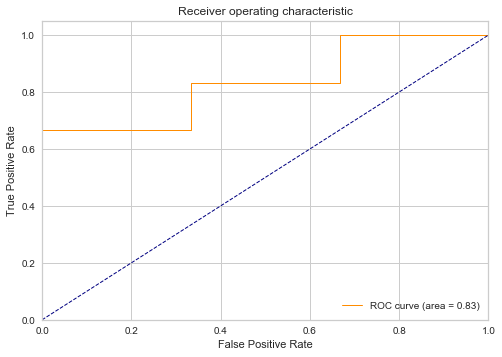

In [250]:
print('Classifier Mass: Linear SVM')
classifierBuild( XMassTrain, yMassTrain, XMassTest, yMassTest, LinearSVC())

FIGURE 1: ROC MASS- FULL FEATURES. CLASSIFIER: LINEAR SVM
AUC: 83%

Classifier Calc: Linear SVM
perform machine learning 
 feature selection 
 model training 
 model selection 
 model evaluation
 Build model, validate and test
(139,)
(155, 1)
Training the model: 
Validation set 10% of total train: 0.625
Accuracy: 0.5333333333333333
Precision: 0.1111111111111111
Recall: 0.2857142857142857
confusion matrix: [[22 16]
 [ 5  2]]


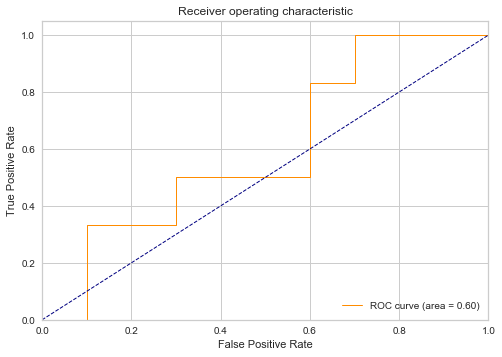

In [251]:
print('Classifier Calc: Linear SVM')
classifierBuild( XCalcTrain, yCalcTrain, XCalcTest, yCalcTest, LinearSVC())

FIGURE 2: ROC CALCIFICATION- FULL FEATURES. CLASSIFIER: LINEAR SVM
AUC: 60%

Classifier Mass:Logistic Regression
perform machine learning 
 feature selection 
 model training 
 model selection 
 model evaluation
 Build model, validate and test
(105,)
(117, 1)
Training the model: 
Validation set 10% of total train: 0.75
Accuracy: 0.48484848484848486
Precision: 0.47368421052631576
Recall: 0.5625
confusion matrix: [[ 7 10]
 [ 7  9]]


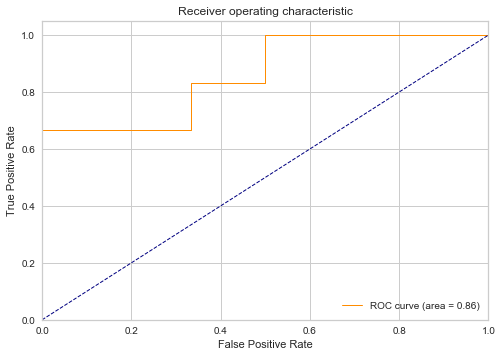

In [252]:
print('Classifier Mass:Logistic Regression')
classifierBuild( XMassTrain, yMassTrain, XMassTest, yMassTest, LogisticRegression())

FIGURE 3: ROC MASS- FULL FEATURES. CLASSIFIER: LOGISTIC REGRESSION
AUC: 86%

Classifier Calc:Logistic Regression
perform machine learning 
 feature selection 
 model training 
 model selection 
 model evaluation
 Build model, validate and test
(139,)
(155, 1)
Training the model: 
Validation set 10% of total train: 0.625
Accuracy: 0.5555555555555556
Precision: 0.15789473684210525
Recall: 0.42857142857142855
confusion matrix: [[22 16]
 [ 4  3]]


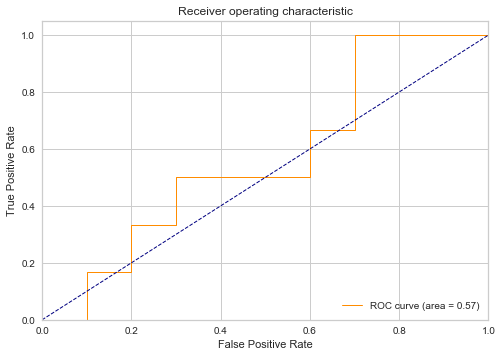

In [253]:
print('Classifier Calc:Logistic Regression')
classifierBuild( XCalcTrain, yCalcTrain, XCalcTest, yCalcTest, LogisticRegression())

FIGURE 4: ROC CALCIFICATION- FULL FEATURES. CLASSIFIER: LOGISTIC REGRESSION
AUC: 57%

Step 7: Dimensionality reduction and evaluation

In [6]:
#X_new = SelectKBest(chi2, k=100).fit_transform(XMassTrain, yMassTrain.ravel())
#print(X_new.shape)
import warnings
warnings.filterwarnings('ignore')
def featureSelection(X_train, y_train):
    #https://www.kdnuggets.com/2018/06/step-forward-feature-selection-python.html
    #STEP FORWARD FEATURE SELECTION
    print('feature selection')


    test = SelectKBest(score_func=chi2, k=500)
    fit = test.fit(X_train, y_train)
    features = fit.transform(X_train)
    return(features,fit)


In [7]:
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
import warnings
warnings.filterwarnings('ignore')

def visual_model_selection(XMassTrain, yMassTrain, XMassTest, yMassTest, estimator):
    """
    Test various estimators.
    """   
    X_train, X_test, y_train, y_test = train_test_split(XMassTrain, yMassTrain, test_size=0.1, random_state=0)
    
    y_train =y_train.ravel()

    y_test =y_test.ravel()
    
    #feat_cols=featureSelection(X_train, y_train)
    X_train_fs=X_train#[:, feat_cols]
    X_test_fs=X_test#[:, feat_cols]
    X_unseen_fs=XMassTest#[:, feat_cols]
    
    clf = Pipeline([
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    clf.fit(X_train_fs, y_train)

    y_pred = clf.predict(X_unseen_fs)
    model = LogisticRegression()
    cm = ConfusionMatrix(clf, classes=[0,1])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
    cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
    cm.score(X_test, y_test)

# How did we do?
    cm.poof()
    y_score = np.array(clf.fit(X_train_fs, y_train).decision_function(X_test_fs))
    y_test_array=np.array(y_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()


In [10]:
import datetime
import warnings
warnings.filterwarnings('ignore')
print(datetime.datetime.now())
print("feature selection-Mass ")
print('Mass feature set original shape:  ',dfMassTrain.shape)
XMassTrainFS,fit=featureSelection(XMassTrain, yMassTrain.ravel())
XMassTestFS=fit.transform(XMassTest)
#print("new featureset length: ", len(feat1_col_mass))
print(datetime.datetime.now())
print("feature selection-Calc ")
print('Calc feature set original shape:  ',dfCalcTrain.shape)
XCalcTrainFS,fit=featureSelection(XCalcTrain, yCalcTrain.ravel())
XCalcTestFS=fit.transform(XCalcTest)
#print("new featureset length: ", len(feat1_col_calc))
print(datetime.datetime.now())

2019-05-27 16:06:50.987936
feature selection-Mass 
Mass feature set original shape:   (117, 66241)
feature selection
2019-05-27 16:06:52.594893
feature selection-Calc 
Calc feature set original shape:   (155, 66241)
feature selection
2019-05-27 16:06:53.641708


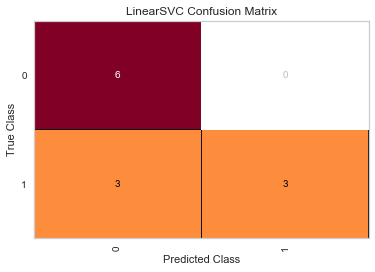

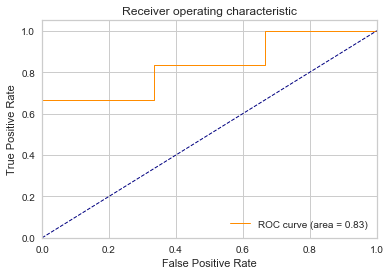


 *****After Feature Selection ****** 



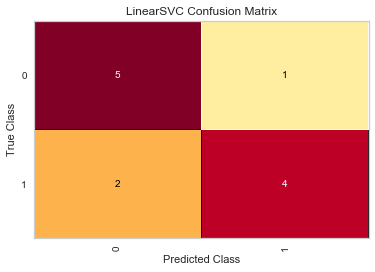

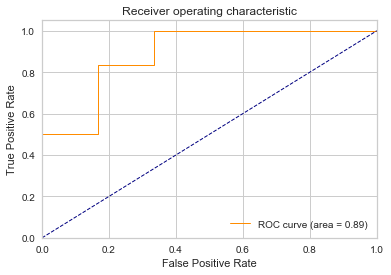

In [11]:
visual_model_selection( XMassTrain, yMassTrain, XMassTest, yMassTest, LinearSVC())
print('\n *****After Feature Selection ****** \n')
visual_model_selection( XMassTrainFS, yMassTrain, XMassTestFS, yMassTest, LinearSVC())

FIGURE 5: MASS ON LINEAR- SVM 
    Feature selection improves the CLASSIFICATION ACCURACY. THERE ARE ALTEAST 2 MALIGNANT CLASSIFIED INTO BENIGN. 
    MALIGNANT FALSE NEGATIVE IS NOT ACCEPTABLE.
    DIMENSIONALITY REDUCTION HAS IMPROVED AUC.

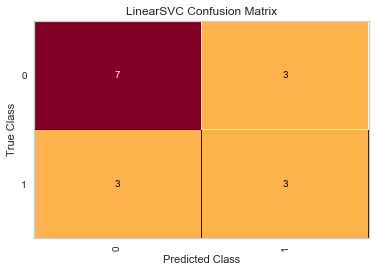

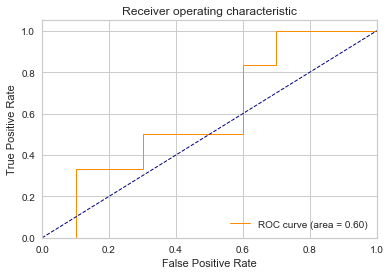


 *****After Feature Selection ****** 



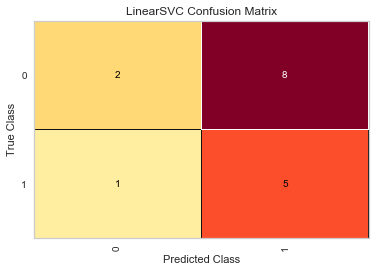

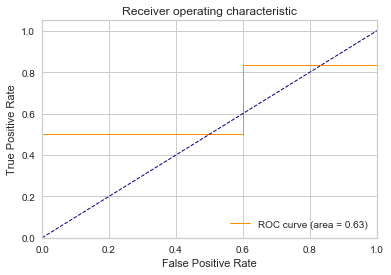

In [12]:
visual_model_selection( XCalcTrain, yCalcTrain, XCalcTest, yCalcTest, LinearSVC())
print('\n *****After Feature Selection ****** \n')
visual_model_selection( XCalcTrainFS, yCalcTrain, XCalcTestFS, yCalcTest, LinearSVC())

FIGURE 6: CALCIFICATION ON LINEAR SVM
    FEATURE SELECTION IMPROVES THE ACCURACY BUT THERE IS GREATER MISCLASSSIFICATION OF BENIGN INTO MALIGNANT. 
    AGAIN 12% FALSE NEGATIVE IS CONCERNING.
    MARGINAL IMPROVEMENT IN AUC AFTER DIMENSIONALITY REDUCTION.

Classifier Mass:Logistic Regression


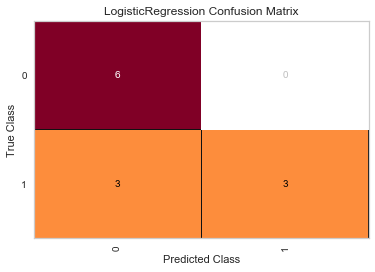

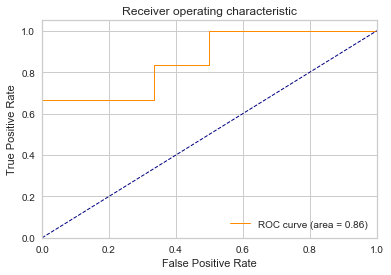

Classifier Mass:Logistic Regression after feature selection


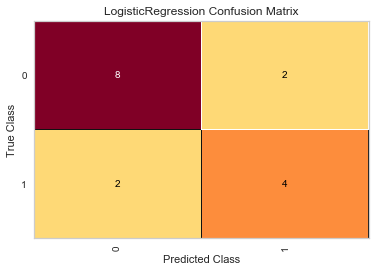

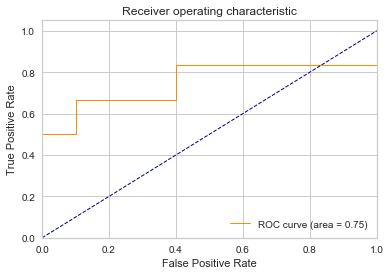

In [13]:
print('Classifier Mass:Logistic Regression')
visual_model_selection( XMassTrain, yMassTrain, XMassTest, yMassTest, LogisticRegression())
print('Classifier Mass:Logistic Regression after feature selection')
visual_model_selection( XCalcTrainFS, yCalcTrain, XCalcTestFS, yCalcTest, LogisticRegression())

FIGURE 7:  MASS ON LOGISTIC REGRESSION. REDUCTION IN AUC AFTER DIMENSIONALITY REDUCTION.

Classifier CALC:Logistic Regression


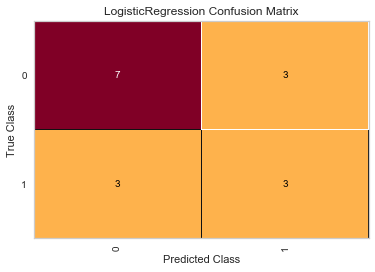

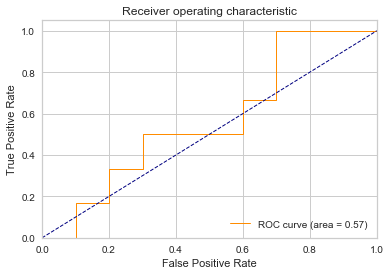

Classifier CALC:Logistic Regression after Feature Selection


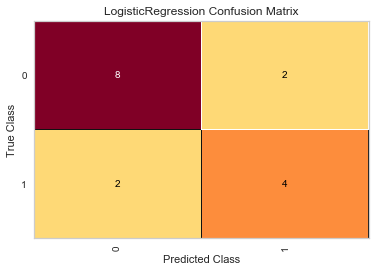

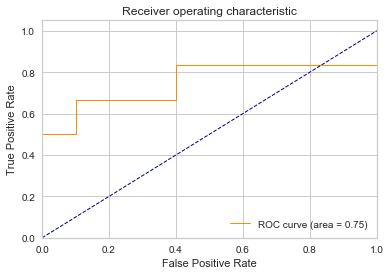

In [14]:
print('Classifier CALC:Logistic Regression')
visual_model_selection( XCalcTrain, yCalcTrain, XCalcTest, yCalcTest, LogisticRegression())
print('Classifier CALC:Logistic Regression after Feature Selection')
visual_model_selection( XCalcTrainFS, yCalcTrain, XCalcTestFS, yCalcTest, LogisticRegression())

 FIGURE 8: CALCIFICATION OF BREATS LESION LOGISTIC REGRESSION
 CONSIDERABLE IMPROVEMENT IN AUC AFTER DIMENSIONALITY REDUCTION.